# Using CEBRA-Time to Analyze OpenScope Data

In this notebook, we will explore the applications of the advanced machine learning algorithm, **CEBRA** (created by the [Mathis Laboratory](http://www.mackenziemathislab.org/)), to analyze OpenScope data from the Allen Institute. **CEBRA** is an algorithm that optimizes neural networks that map neural activity onto an embedding space. This algorithm leverages **[contrastive learning](http://proceedings.mlr.press/v119/chen20j/chen20j.pdf)** and a generalized **[InfoNCE loss function](https://www.nature.com/articles/s41586-023-06031-6#Sec11)** to learn representations where similar data points are pulled closer together while dissimilar data points are pushed apart within the embedding space. CEBRA has three different modes: **CEBRA-Time** (fully unsupervised/self supervised), **CEBRA-Behavior** (supervised), and **CEBRA-Hybrid**.

In this notebook, we will be utilizing **CEBRA-Time**, so our input data will be unlabeled and there will be no behavioral assumptions that influence neuronal activity. We utilize **CEBRA-Time** to create a 3D latent embedding space of a mouse’s neural activity while passively viewing visual stimuli. This algorithm can help us identify patterns in neural activity and its relationship to the visual stimulus. We use the neural data to train the model, generate embeddings for each type of visual stimulus, and plot different subsections of the data separately onto the same embedding space.

Below is a visualization of the pipeline that displays the steps from how the algorithm receives input data to how the final output of the embedding is produced. To briefly describe how it works, **CEBRA** takes input in the form of *positive and negative pairs* of data relative to a reference point. An example of a positive and negative pair for behavioral labels would be two positions on a track that are close together in space versus a position on a track that is far away. Likewise, for time labels, a positive pair would be data from two points that occur close together in time versus a data point that occurs farther away in time. Next, a nonlinear encoder receives the data in the form of a triplet that contains 3 vectors: neural data from the positive points, neural data from the negative points, and neural data from the reference points. The nonlinear encoder maps the raw neural data onto a lower dimensional feature space. Here, **CEBRA** leverages *contrastive learning* to learn representations where similar pairs are pulled closer together and dissimilar pairs are pushed apart in an embedding space. During training, similarity scores are computed for positive and negative pairs. A modified *InfoNCE loss function* is calculated and gradient descent is used to optimize the loss. Once the network is fully trained, the lower-dimensional embedding space is produced from the final output layer.

For further details on **CEBRA**, you can refer to [the paper published by the Mathis Lab](https://www.nature.com/articles/s41586-023-06031-6) or visit the [CEBRA website](https://cebra.ai/docs/index.html) to gain a deeper understanding on these concepts. Understanding how the input data is processed is important as well as how each point in the embedding relates to a given input.

Additionally, in this notebook, we will be using open source data published by the Allen Institute titled [Measuring Stimulus-Evoked Neurophysiological Differentiation in Distinct Populations of Neurons in Mouse Visual Cortex](https://pubmed.ncbi.nlm.nih.gov/35022186/). This study employs **[two-photon calcium imaging](https://www.pnas.org/doi/epdf/10.1073/pnas.1232232100)** to study stimulus-evoked neuronal response in excitatory neurons in five different visual cortical areas. Recordings were taken from mice during passive viewing of either naturalistic or phase-scrambled movie stimuli. During the viewing, each stimulus type was repeated 10 times, nonconsecutively. Our objective is to use **CEBRA** to generate an embedding space that is consistent across movie repeat. Essentially, we aim to extract a representation of the movie that could be present in the neuronal activity across all repeats.


![cebra_pipeline.png](../../data/images/cebra_pipeline.png)

Figure 1a, *[Learnable latent embeddings for joint behavioural and neural analysis](https://www.nature.com/articles/s41586-023-06031-6)*

### Notebook Settings for Google Colab
To ensure the fastest and runtime, check to make sure your hardware accelerator is using GPU. This should be pre-set for the notebook, but here are the steps to double-check it is set correctly:
1. click "Edit" below the notebook title
2. near the bottom of the list click "Notebook settings"
3. In the "Hardware Accelerator" dropdown, click "GPU"
4. select the "GPU type" that you please
5. click "Save" and run the notebook


### Create CEBRA Environment and Download Dependencies

**⚠️Note: If running on a new environment, run this cell once and then restart the kernel⚠️**

In [4]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [5]:
# install other dependencies
import cebra
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from cebra import CEBRA
from scipy import interpolate
from scipy.stats import ttest_ind

%matplotlib inline

### Download Data

We download the data using the same process as in previous notebooks. If you need help downloading OpenScope data, see the [Downloading an NWB File](https://github.com/AllenInstitute/openscope_databook/blob/main/docs/basics/download_nwb.ipynb) notebook.

In [6]:
# download ophys files
dandiset_id = "000036"
dandi_filepath = "sub-389014/sub-389014_ses-20180705T152908_behavior+image+ophys.nwb"
download_loc = "."
dandi_api_key = None

In [7]:
# download data
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.56.0) of dandi/dandi-cli is available. You are using 0.55.1


PATH                                                    SIZE   DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-389014_ses-20180705T152908_behavior+image+ophys.nwb 1.3 GB 1.3 GB          100%    ok    done                   
Summary:                                                1.3 GB 1.3 GB                        1 done                 
                                                               100.00%                                              
Downloaded file to ./sub-389014_ses-20180705T152908_behavior+image+ophys.nwb
Opening file


/Users/jerome.lecoq/opt/miniconda3/envs/databook_cebra/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/jerome.lecoq/opt/miniconda3/envs/databook_cebra/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/jerome.lecoq/opt/miniconda3/envs/databook_cebra/lib/python3.10/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'running_velocity': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
/Users/jerome.lecoq/opt/m

### Setting Up The Stimulus Table
The stimulus table below includes information about the type of visual stimulus that was presented to the mice during the passive viewing experiment. It contains the start and stop time for each presentation of a frame, the frame number, and the stimulus type. The frame number helps us to identify the exact part of the movie the mouse is viewing. Before proceeding with the rest of the code, it's advisable to become familiar with the stimulus table and the data it contains. Understanding the structure and content of the stimulus table will help with comprehending the subsequent code.

The function `stim_obj_to_table` retrieves `start_times`, `stop_times`, `frames`, and `stim-type` from an NWB file and then organizes that data into a pandas dataframe. Pandas dataframes are a very useful way to organize, manipulate, and explore data.

In [10]:
# use this if nwb intervals section has no stim information
def stim_obj_to_table(nwb):

    all_labeled_stim_timestamps = []
    for stim_type, stim_obj in nwb.stimulus.items():
        start_times = stim_obj.timestamps[:-1]
        stop_times = stim_obj.timestamps[1:]
        frames = stim_obj.data[:-1]
        l = len(start_times)
        labeled_timestamps = list(zip(start_times, stop_times, frames, [stim_type]*l))
        all_labeled_stim_timestamps += labeled_timestamps

    all_labeled_stim_timestamps.sort(key=lambda x: x[0])
    stim_table = pd.DataFrame(all_labeled_stim_timestamps, columns=("start time", "stop time", "frame", "stimulus type"))

    return stim_table

stim_table = stim_obj_to_table(nwb)

In [11]:
# view the stimulus table
stim_table

,start time,stop time,frame,stimulus type
0,27.475720,27.492416,0,spontaneous
1,27.492416,27.509112,0,spontaneous
2,27.509112,27.525758,0,spontaneous
3,27.525758,27.542211,0,spontaneous
4,27.542211,27.559146,0,spontaneous
...,...,...,...,...
241181,4231.635599,4231.652274,897,snake
241182,4231.652274,4231.668936,897,snake
241183,4231.668936,4231.685619,898,snake
241184,4231.685619,4231.702325,898,snake


### Extracting DFF Data
The neural data we are trying to analyze is contained in a 2D array called `dff_trace` and has a shape of (127117, 41) -- this will vary for different datasets. From the shape, we can tell that there are 41 regions of interest (or neurons) and 127177 measurements of fluorescence for each neuron. This will produce a matrix with 127177 rows and 41 columns. Each of the 127177 measurements are taken at the same time for each neuron. For example, [5][0] (first ROI 6th measurement) will have a different fluorescence value than [5][33] (34th ROI, 6th measurement) but these measurements will have been taken at the same time during the trial. The timestamps for each fluorescence value are contained in the `dff_timestamps` array that should have the same length as `dff_trace`.

In [12]:
# access the data we want
dff = nwb.processing["ophys"]["DfOverF"]
dff_trace = np.array(dff.roi_response_series["imaging_plane_1"].data).transpose()
dff_timestamps = dff.roi_response_series["imaging_plane_1"].timestamps[:-1]

In [13]:
print(dff_trace.shape)
print(dff_timestamps.shape)

(127177, 41)
(127177,)


### Aligning Different Types of Data

Currently, we have data from the stimulus table and neural data collected during the 2P imaging. Since the data is from two different places, it is essential to make sure they are aligned by time. The data from the stimulus table includes the start and stop time of each frame of the visual stimulus, the frame number, and the type of visual stimulus that is presented. The purpose of the code below is to identify a frame number and stimulus type for each value in `dff_timestamps`. Once we have the timestamps aligned with the data in the stimulus table, we can properly index and label the fluorescence traces from `dff_traces` that will be inputted into **CEBRA-Time**.

In [14]:
# retrieve intervals of time associated with each frame
frame_intervals = []
frame_list = []
stim_type_list = []

frame_start = stim_table['start time'][0]
frame_end = stim_table['stop time'][0]

for i in range(len(stim_table)):
    if i+1 == len(stim_table):
        continue
    current_frame = stim_table['frame'][i]
    next_frame = stim_table['frame'][i + 1]
    next_start_time = stim_table['start time'][i+1]
    next_stop_time = stim_table['stop time'][i+1]
    current_stim = stim_table['stimulus type'][i]
    next_stim = stim_table['stimulus type'][i+1]

    # appends the start and stop time for each individual frame to get a list of frame intervals
    if current_frame != next_frame or current_stim != next_stim:
        frame_end = next_start_time
        frame_intervals.append((frame_start, frame_end))
        frame_list.append(current_frame)
        stim_type_list.append(current_stim)
        frame_start, frame_end = next_start_time, next_stop_time

In [15]:
# now we can identify the interval of time each frame is displayed
print(len(frame_intervals))
print(len(frame_list))

136798
136798


In the following cell, the two lists `timestamp_frames` and `timestamp_stimulus` will be appended to contain the visual movie frames and the stimulus type for each point in the `dff_timestamps` array. After the while-loop is complete, we will have a list of frames and stimulus types and should be aligned with the `dff_timestamps` array. This is useful for indexing later in the notebook.

In [16]:
# matches each timestamp from 'dff_timestamps' with its corresponding frame in 'frame_list'
i, j = 0, 0
timestamp_frames =  [] # will contain list of frames associated with each timestamp
timestamp_stimulus = [] # will contain list of stimulus type associated with each timestamp
count_times_before_stim = 0

while i < len(dff_timestamps) and j < len(frame_intervals):
    this_timestamp = dff_timestamps[i]
    start_time, stop_time = frame_intervals[j]
    this_stimulus = stim_type_list[j]
    this_frame = frame_list[j]

    ### uncomment these print statements to check if the loop is working with your data
    #print(this_timestamp)
    #print(this_interval)
    #print(this_frame)
    #print(this_stimulus)

    if this_timestamp >= start_time and this_timestamp <= stop_time:
        timestamp_frames.append(this_frame)
        timestamp_stimulus.append(this_stimulus)
        i += 1
    elif this_timestamp < start_time:
        i += 1
        count_times_before_stim += 1
    else:
        j += 1

Here, we run into an issue: `timestamp_frames` and `timestamp_stimulus` have a different length than `dff_timestamps`. This means that if we try to index a timestamp using an index value from the frames list, it will correspond with the wrong timestamp value. When comparing the stimulus table to the timestamps array, total time in seconds from the stimulus table is less than the total time accounted for in `dff_timestamps`, meaning there are some timestamps that do not correspond with any frame or any stimulus type. In other words, some timestamps occur before or after the duration of stimulus presentation. To correctly align the data, we need to slice `dff_timestamps` to only include timestamps that correspond with a visual stimulus.

In [17]:
# the length of timestamp_frames is different than the length of dff_timestamps and we need to figure out why
print(len(timestamp_frames))
print(len(timestamp_stimulus))
print(len(dff_timestamps))

print('number of timestamps unaccounted for: ', len(dff_timestamps)-len(timestamp_frames))

126758
126758
127177
number of timestamps unaccounted for:  419


In [18]:
# number of dff_timestamps that occur before the first frame is presented (while timestamp < start_time)
print('number of timestamps that occur before stimulus: ', count_times_before_stim)

# find how many dff_timestamps occur after the last visual stimulus is displayed
max_frame_time = np.max(frame_intervals)
max_timestamp_allowed = np.where(dff_timestamps > max_frame_time)[0][0]

# find the last timestamp that occurs during stimulus presentation
timestamps_before_stim_end = len(dff_timestamps) - (len(dff_timestamps)- max_timestamp_allowed)
print('last timestamp that occurs during stimulus presentation: ', timestamps_before_stim_end)

# slice `dff_timestamps` to only include timestamps that correlate with frames
sliced_dff_timestamps = dff_timestamps[count_times_before_stim:timestamps_before_stim_end]
print('New length of dff_timestamps: ', len(sliced_dff_timestamps))

# this aligns the dff_trace with sliced version of the dff_timestamps so that we can correctly index the neural data
sliced_dff_trace = dff_trace[count_times_before_stim:timestamps_before_stim_end]
print('New length of dff_trace: ', len(sliced_dff_trace))


number of timestamps that occur before stimulus:  133
last timestamp that occurs during stimulus presentation:  126891
New length of dff_timestamps:  126758
New length of dff_trace:  126758


Now that all of our data is aligned by time and shape, we can create a 2D array that includes each timestamp and its correlated frame number and stimulus type. While this array might not be directly useful for **CEBRA-Time**, it can be useful in the future for **CEBRA-Behavior**, and can easily be converted to a pandas dataframe.

In [19]:
timestamp_frames = np.asarray(timestamp_frames)
timestamp_stimulus = np.asarray(timestamp_stimulus)

# produces a 2D array with dff_timestamps, frame number, and stim type
times_frames_stimtype = np.stack((sliced_dff_timestamps, timestamp_frames, timestamp_stimulus))
times_frames_stimtype = np.transpose(times_frames_stimtype)
print(times_frames_stimtype.shape)
print(times_frames_stimtype)

(126758, 3)
[['27.47572' '0' 'spontaneous']
 ['27.50889' '0' 'spontaneous']
 ['27.54205' '0' 'spontaneous']
 ...
 ['4231.61079' '896' 'snake']
 ['4231.64396' '897' 'snake']
 ['4231.67713' '898' 'snake']]


### Perform a GRID-search for training hyper parameters

This algorithm training code was borrowed from the [Demo Hypothesis Testing Notebook](https://cebra.ai/docs/demo_notebooks/Demo_hypothesis_testing.html) provided by the Mathis Lab, the creators of **CEBRA**. If you are interested in the specifics of how the network is trained in the code below, you can view the documentation on the [CEBRA website](https://cebra.ai/docs/api/sklearn/cebra.html). 

**CEBRA** provides a number of degrees of freedom to optimize the final embedding. It is important that you use a set of parameters that produce consistent embedding with low reconstruction loss. To fine-tune this parameters, **CEBRA** provide functionalities to perform a grid-search. Below, we provide example code to look for the optimal set of parameters for this datasets. Keep in mind that making sure this selection generalizes well to new datasets is important to avoid over-fitting. This search is rather intensive, so it is recommended to run this on a good machine. We found that the T4 units on DandiArchive were fairly good at the moment and would run this search in less than an hour. 

In [26]:
# First you define the parameter to explore. Here we explore the output dimension, learning rate, time offset, and model num_hidden_units.
params_grid = dict(
    output_dimension = [16, 32, 64, 128],
    learning_rate = [0.001, 0.01, 0.0003],
    time_offsets = [10, 20],
    model_architecture='offset10-model',
    batch_size=512,
    temperature_mode='constant',
    max_iterations=[10], # we initially set this low to limit computation and will increase it later to fully train the best model
    distance='cosine',
    conditional='time',
    device='cuda_if_available',
    num_hidden_units = [32, 64, 128],
    temperature=1,
    verbose = True)

# we construct the input data
datasets = {"dataset1": sliced_dff_trace} # a different set of data

# we run the grid search
grid_search = cebra.grid_search.GridSearch()
grid_search.fit_models(datasets=datasets, params=params_grid, models_dir="saved_models")

  0%|          | 0/10 [00:00<?, ?it/s]

pos:  0.3761 neg:  5.6090 total:  5.9851 temperature:  1.0000: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]
pos:  0.4351 neg:  5.6373 total:  6.0724 temperature:  1.0000: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]
pos:  0.3607 neg:  5.8224 total:  6.1831 temperature:  1.0000: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]
pos:  0.3077 neg:  5.6856 total:  5.9933 temperature:  1.0000: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]
pos:  0.2773 neg:  5.8401 total:  6.1174 temperature:  1.0000: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]
pos:  0.1903 neg:  5.9919 total:  6.1823 temperature:  1.0000: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]
pos:  0.1841 neg:  5.8830 total:  6.0671 temperature:  1.0000: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]
pos:  0.2225 neg:  5.8823 total:  6.1049 temperature:  1.0000: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]
pos:  0.1365 neg:  6.0662 total:  6.2027 temperature:  1.0000: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]
p

You can access the underlying grid-search object to select the best model of visualise the best set of parameters. The models are saved in a "saved_models" folder along with the notebook.

In [27]:
df_results = grid_search.get_df_results(models_dir="saved_models")
best_model, best_model_name = grid_search.get_best_model(dataset_name="dataset1", models_dir="saved_models")

This is the distibution of loss values in the end

In [54]:
pd_loss

,learning_rate,num_hidden_units,output_dimension,time_offsets,loss,dataset_name,params
0,0.0010,32,16,10,5.985058,dataset1,0.001_32_16_10
1,0.0010,32,16,20,6.072386,dataset1,0.001_32_16_20
2,0.0010,32,16,60,6.183132,dataset1,0.001_32_16_60
3,0.0010,32,32,10,5.993285,dataset1,0.001_32_32_10
4,0.0010,32,32,20,6.117390,dataset1,0.001_32_32_20
...,...,...,...,...,...,...,...
103,0.0003,128,64,20,6.046776,dataset1,0.0003_128_64_20
104,0.0003,128,64,60,6.120140,dataset1,0.0003_128_64_60
105,0.0003,128,128,10,5.975000,dataset1,0.0003_128_128_10
106,0.0003,128,128,20,6.056667,dataset1,0.0003_128_128_20


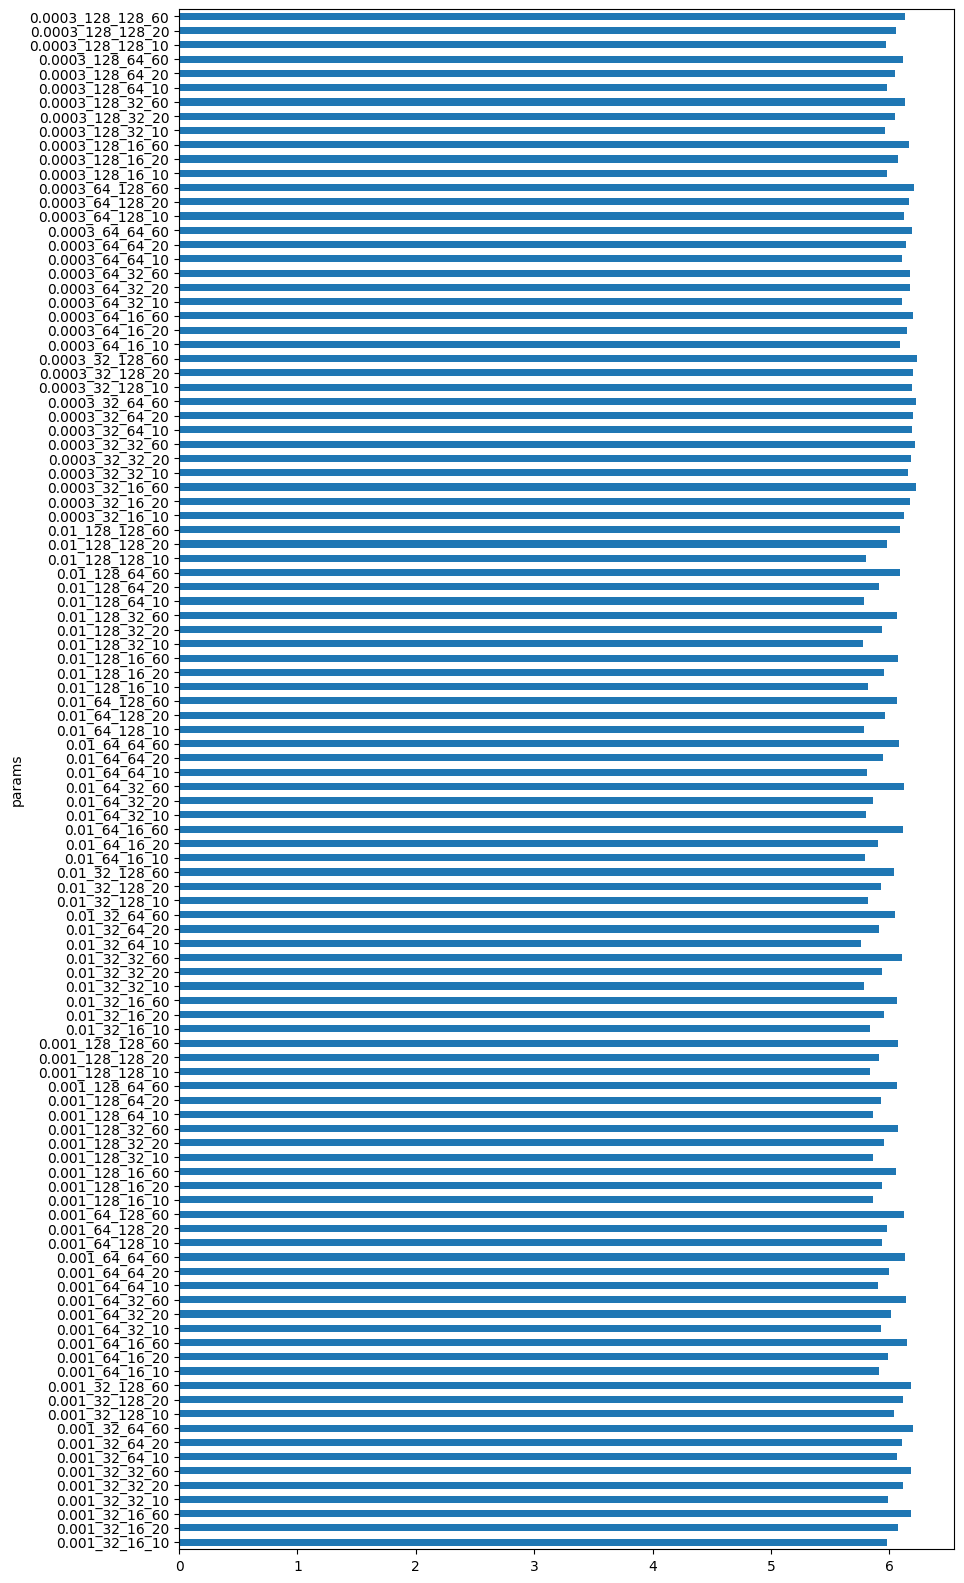

In [55]:
# Get all the final losses
pd_loss = grid_search.get_df_results()

# Plot the losses for each parameter combination in a bar plot
# The y-axis is the parameter combination and the x-axis is the loss
# We combine the parameters into a single string for the x-axis
pd_loss['params'] = pd_loss['learning_rate'].astype(str) + '_' + pd_loss['num_hidden_units'].astype(str) + '_' + pd_loss['output_dimension'].astype(str) + '_' + pd_loss['time_offsets'].astype(str)

pd_loss.plot.barh(x='params', y='loss', figsize=(10, 20))

# We turn off the legend from the plot
plt.gca().legend_.remove()


In [56]:
best_model

CEBRA(batch_size=512, conditional='time', learning_rate=0.01, max_iterations=10,
      model_architecture='offset10-model', output_dimension=64, temperature=1,
      time_offsets=10, verbose=True)

In [57]:
best_model_name

'learning_rate_0.01_num_hidden_units_32_output_dimension_64_time_offsets_10_dataset1'

### Train CEBRA-Time Model

Here, we use our insight from the grid-search to fully train the **CEBRA** model using the neural data (`sliced_dff_trace`). Training the model can take anywhere from a few minutes to a few hours depending on the size of the dataset you are inputting. If you want to lower CPU usage, or if you want to experiment quickly with the model, it's best to either use a smaller slice of the data you input, or lower the number of max iterations. Keep in mind, this will lower the quality of the embedding space.

In [58]:
# alter the number of max_iterations to get a faster runtime
max_iterations = 10000 # default is 5000

In [59]:
# set conditional to 'time'
cebra_time_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=1e-2,
                        temperature=1,
                        output_dimension=32,
                        num_hidden_units=128,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [60]:
# insert the data you want to train in .fit()
cebra_time_model.fit(sliced_dff_trace)
cebra_time_model.save("cebra_time_model.pt")

pos:  0.2926 neg:  5.4061 total:  5.6987 temperature:  1.0000:   1%|          | 53/10000 [00:28<1:29:28,  1.85it/s]


KeyboardInterrupt: 

### Evaluate The Loss
Here, we plot the loss function of the algorithm. **CEBRA** uses the *InfoNCE loss function* to serve as a *goodness-of-fit metric to the data*, and helps determine which variables have the largest influence on the data. The goal is to minimize loss, so if your network is well trained, you should see a low loss value. Typically, a loss value less than 7 indicates the model is well train on the data.

In [ ]:
# this plots the loss from the model we saved in the previous cell
cebra.plot_loss(cebra_time_model, color = 'tab:blue')

: 

: 

: 

: 

: 

### Produce Embedding Spaces for CEBRA-Time

Now, we want to determine if **CEBRA-Time** can produce a clear embedding space for our data. For this dataset, when we plotted all the points of neural data onto one embedding space, it was difficult to visually detect patterns in the data. A solution to this problem is to create many different plots of the same embedding space that contain different sections of the data. Below, we separate our neural data by stimulus type and then for each stimulus type, we plot each repeat of the movie separately onto the embedding space. We also color the points on the embedding space based on the movie frame. This means that frames that are shown close together in time will have similar colors. For reference, there are 10 repeats of each stimulus type (except for dots), and each repeat contains 899 frames. We have also excluded three stimulus types ('snake', 'noise', and 'spontaneous') from the plots because they did not repeat, or contained issues within the repeats. The hope is that each repeat of each movie will be plotted similarly onto the embedding space, and ultimately, each stimulus type will be differentiable when plotted onto one large embedding space.

First, we create a function that selects neural data based on one repeat of the movie. We index the neural data with the indices of a particular movie repeat, and then load that indexed neural data into the trained **CEBRA** model which will be used to produce one plot of the embedding space. We also index the frames associated with each point of neural data based on the same indices, and use the value of each frame to create color labels for the embedding space. Next, we create a function that plots each model separately. In the following cell, we use a for-loop to loop through each stimulus, and within that stimulus, we loop through each repeat. For each repeat, we call the two functions and are able to produce a plot of the embedding space for that specific slice of data.


In [ ]:
### inputs fluorescence traces for each repeat of the stimulus into the model and gets colors for embedding space
### returns an embedding space of points and color labels for each point
def get_embeddings(selected_frames, individual_dff_input, movie_repeat_indices):

    # takes fluorescence traces from particular stimulus interval and selects only traces for one specific repeat
    movie_repeat_input = individual_dff_input[movie_repeat_indices]

    # inputs neural data for each individual repeat into model
    cebra_time_model = cebra.CEBRA.load("cebra_time_model.pt")
    cebra_time = cebra_time_model.transform(movie_repeat_input)

    # create color labels for embedding
    color_labels = []
    # takes frames of visual movie for a particular stimulus and selects only frames from a specific repeat of the movie
    repeat_frames = selected_frames[movie_repeat_indices]
    for frame in repeat_frames:
        total_frames = np.max(repeat_frames)
        # allows frames that are close together in time to be colored similarly
        value = frame/total_frames
        color_labels.append(value)

    color_labels = np.asarray(color_labels)
    return cebra_time, color_labels

: 

: 

: 

: 

: 

In [ ]:
### plots embedding space for one repeat of the visual stimulus
def create_subplots(cebra_time_models_list, cebra_embedding_colors_list):
    fig = plt.figure(figsize=(20, 7))

    # 'count_of_repeat' allows us to title the plot based on the movie repeat
    count_of_repeat = 0
    plt.title(f'CEBRA-Time - {stim_name}')
    plt.gca().axis('off')

    # iterates through the list of cebra models and makes one plot for each model
    for i in range(len(cebra_time_models_list)):
        ax = fig.add_subplot(1, len(cebra_time_models_list), i+1, projection='3d')
        count_of_repeat += 1

        ax = cebra.plot_embedding(ax=ax, embedding=cebra_time_models_list[i], embedding_labels=cebra_embedding_colors_list[i], markersize=1, title=f'{count_of_repeat}')

    return plt.show()

: 

: 

: 

: 

: 

In [ ]:
# provides the names of each stimulus type from the stim table
stimulus_names = set(stim_table['stimulus type'])

# loops through each stimulus type and selects the indices for every occurance of that stimulus throughout the entire movie
for stim_name in stimulus_names:
    selected_indices = np.where(timestamp_stimulus == stim_name)[0]

    # excludes stimuli that do not exist or produce errors
    if len(selected_indices) == 0:
        print(f"{stimulus_names} not found")
    elif stim_name == "snake" or stim_name == "spontaneous":
        print("Invalid stim")
    # selects the visual movie frames and neural data for each different stimulus type
    else:
        selected_frames = timestamp_frames[selected_indices]
        individual_dff_input = sliced_dff_trace[selected_indices]

        movie_repeat_indices = []
        cebra_time_model_list = []
        cebra_embedding_colors_list = []

        # loops through each frame in the movie for a particular stimulus type and appends the index
        for i, frames in enumerate(selected_frames[:-1]):
            
            # We exclude the last frame of the movie that is repeated in the index due to edge conditions
            if frames<np.max(selected_frames):
                movie_repeat_indices.append(i)

            if selected_frames[i+1] == 0 or i == (len(selected_frames)-2):
                # use the function from above to get the cebra model and time embeddings for each repeat of the movie
                cebra_time, embedding_color_labels = get_embeddings(selected_frames, individual_dff_input, movie_repeat_indices)

                # append the model and embedding colors for each repeat to a list to be used in the plotting function
                cebra_time_model_list.append(cebra_time.copy())
                cebra_embedding_colors_list.append(embedding_color_labels.copy())

                movie_repeat_indices.clear()

        cebra_time_model_list = np.asarray(cebra_time_model_list, dtype=object)
        cebra_embedding_colors_list = np.asarray(cebra_embedding_colors_list, dtype=object)

        # use the function from above to create a plot of each model from the list we just made and color them using the corresponding embedding color list
        create_subplots(cebra_time_model_list, cebra_embedding_colors_list)

: 

: 

: 

: 

: 